# Mass/Calcification


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini'

In [ ]:
def toRGB(images):
  tmp_images = []
  for image in images:
    reshaped_image = image[0].reshape((150,150,1))
    rgb_image = np.repeat(reshaped_image, 3, 2)
    rgb_image = rgb_image / 65535
    reshaped_image = image[1].reshape((150,150,1))
    rgb_image2 = np.repeat(reshaped_image, 3, 2)
    rgb_image2 = rgb_image / 65535
    tmp_images.append((rgb_image,rgb_image2))

  tmp_images = np.array(tmp_images)
  return tmp_images

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==2:#mass
      new_labels.append(0)
    if label==3 or label==4:#calcification
      new_labels.append(1)
  return np.array(new_labels)

In [ ]:
def change_label_bm(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==3:#benign
      new_labels.append(0)
    if label==2 or label==4:#malignant
      new_labels.append(1)
  return np.array(new_labels)

In [3]:
model1 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_siamese_dof"))#siamese learning VGG16
model2 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_siamese_deep_fusion"))#siamese learning VGG16 with deep fusion
model3 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_multimodal_v1"))#multi modal difference with same networks
model4 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_multimodal_v2"))# multi modal difference with different networks
model5 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_multimodal_v3"))# multi modal deep fusion with same networks
model6 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_multimodal_v4"))# multi modal deep fusion with different networks
model7 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_concatenated_input"))# concatenated input

In [ ]:

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')

test_images_labels = change_label(test_images_labels[1::2])

# transform array in pairs of (baseline,patch)
N = len(test_images_tensor)
tmp = []
for i in range(0,N,2):
  tmp1 = test_images_tensor[i]
  tmp2 = test_images_tensor[i+1]
  image = (tmp1,tmp2)
  tmp.append(image)
test_images_tensor = np.array(tmp)
print(test_images_tensor.shape)

test_images_tensor = toRGB(test_images_tensor)
print(test_images_tensor.shape)

tmp_test = np.split(test_images_tensor, 2, axis=1)
tmp_test[0] = tmp_test[0].reshape((336,150,150,3))
tmp_test[1] = tmp_test[1].reshape((336,150,150,3))

(336, 2, 150, 150)
(336, 2, 150, 150, 3)


In [ ]:
# Test set 

predictions1 = (model1.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")
predictions2 = (model2.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")
predictions3 = (model3.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")
predictions4 = (model4.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")
predictions5 = (model5.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")
predictions6 = (model6.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")


In [ ]:
def concatenate_abnormality_baseline(abnormality_images, baseline_images):
  images = []
  for (abnormality, baseline) in zip(abnormality_images, baseline_images):
    images.append(np.concatenate((abnormality.reshape((150,150,1)), baseline.reshape((150,150,1))), axis=2))
  images = np.array(images)
  return images


In [ ]:
test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor_abnormality = test_images_tensor[1::2]
test_images_tensor_baseline = test_images_tensor[0::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label(test_images_labels)



test_images_tensor = concatenate_abnormality_baseline(test_images_tensor_abnormality, test_images_tensor_baseline)

predictions7 = (model7.predict(test_images_tensor) > 0.5).astype("int32")

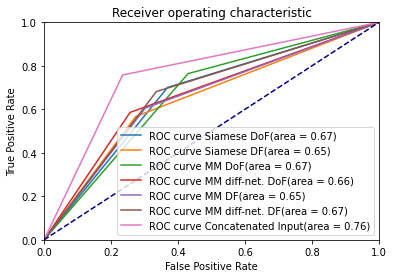

In [ ]:
from sklearn import metrics
import seaborn as sn
import pandas as pd

fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,predictions1)
fpr2,tpr2,th2 = metrics.roc_curve(test_images_labels,predictions2)
fpr3,tpr3,th3 = metrics.roc_curve(test_images_labels,predictions3)
fpr4,tpr4,th4 = metrics.roc_curve(test_images_labels,predictions4)
fpr5,tpr5,th5 = metrics.roc_curve(test_images_labels,predictions5)
fpr6,tpr6,th6 = metrics.roc_curve(test_images_labels,predictions6)
fpr7,tpr7,th7 = metrics.roc_curve(test_images_labels,predictions7)

roc_auc1 = metrics.roc_auc_score(test_images_labels,predictions1)
roc_auc2 = metrics.roc_auc_score(test_images_labels,predictions2)
roc_auc3 = metrics.roc_auc_score(test_images_labels,predictions3)
roc_auc4 = metrics.roc_auc_score(test_images_labels,predictions4)
roc_auc5 = metrics.roc_auc_score(test_images_labels,predictions5)
roc_auc6 = metrics.roc_auc_score(test_images_labels,predictions6)
roc_auc7 = metrics.roc_auc_score(test_images_labels,predictions7)


from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve Siamese DoF(area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='ROC curve Siamese DF(area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='ROC curve MM DoF(area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='ROC curve MM diff-net. DoF(area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='ROC curve MM DF(area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, label='ROC curve MM diff-net. DF(area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, label='ROC curve Concatenated Input(area = %0.2f)' % roc_auc7)


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



# Benign/Malignant

In [4]:
model1 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_concatenated_input_bm"))# concatenated input bm
model2 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_multimodal_bm"))#multi modal different networks deep fusion bm
model3 = tf.keras.models.load_model(os.path.join(out_path, "models/baseline_siamese_bm"))#siamese difference of features bm

(336, 2, 150, 150)
(336, 2, 150, 150, 3)


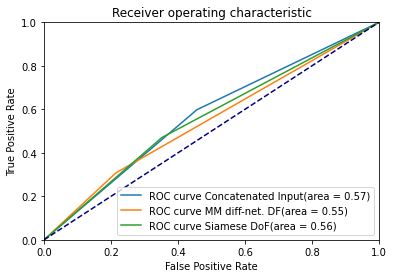

In [ ]:
from sklearn import metrics
import seaborn as sn
import pandas as pd

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor_abnormality = test_images_tensor[1::2]
test_images_tensor_baseline = test_images_tensor[0::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label_bm(test_images_labels)
test_images_tensor = concatenate_abnormality_baseline(test_images_tensor_abnormality, test_images_tensor_baseline)

predictions1 = (model1.predict(test_images_tensor) > 0.5).astype("int32")


test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')

test_images_labels = change_label_bm(test_images_labels[1::2])
# transform array in pairs of (baseline,patch)
N = len(test_images_tensor)
tmp = []
for i in range(0,N,2):
  tmp1 = test_images_tensor[i]
  tmp2 = test_images_tensor[i+1]
  image = (tmp1,tmp2)
  tmp.append(image)
test_images_tensor = np.array(tmp)
print(test_images_tensor.shape)

test_images_tensor = toRGB(test_images_tensor)
print(test_images_tensor.shape)

tmp_test = np.split(test_images_tensor, 2, axis=1)
tmp_test[0] = tmp_test[0].reshape((336,150,150,3))
tmp_test[1] = tmp_test[1].reshape((336,150,150,3))

predictions2 = (model2.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")
predictions3 = (model3.predict((tmp_test[0],tmp_test[1])) > 0.5).astype("int32")



fpr1,tpr1,th1 = metrics.roc_curve(test_images_labels,predictions1)
fpr2,tpr2,th2 = metrics.roc_curve(test_images_labels,predictions2)
fpr3,tpr3,th3 = metrics.roc_curve(test_images_labels,predictions3)


roc_auc1 = metrics.roc_auc_score(test_images_labels,predictions1)
roc_auc2 = metrics.roc_auc_score(test_images_labels,predictions2)
roc_auc3 = metrics.roc_auc_score(test_images_labels,predictions3)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve Concatenated Input(area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='ROC curve MM diff-net. DF(area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='ROC curve Siamese DoF(area = %0.2f)' % roc_auc3)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



In [ ]:
# F2 metric for BM models
from sklearn.metrics import fbeta_score

print(fbeta_score(test_images_labels, predictions1, beta=2))
print(fbeta_score(test_images_labels, predictions2, beta=2))
print(fbeta_score(test_images_labels, predictions3, beta=2))

0.54858934169279
0.32667876588021777
0.45833333333333337
